### Import Efficient 3DCNN MobileNetV2

In [1]:
import sys
sys.path.append('./Face Liveness/Models/Efficient-3DCNNs-master/models')

In [2]:
from mobilenetv2 import MobileNetV2, get_model, get_fine_tuning_parameters

In [3]:
# Create an instance of the MobileNetV2 model
model = MobileNetV2(num_classes=27, sample_size=112, width_mult=0.45)

In [4]:
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv3d(3, 14, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv3d(14, 14, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=14, bias=False)
        (1): BatchNorm3d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv3d(14, 7, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (4): BatchNorm3d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv3d(7, 42, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (1): BatchNorm3d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): 

### Load the pre-train / checkpoint

In [5]:
import torch

checkpoint_path = './jester_mobilenetv2_0.45x_RGB_16_best.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

C:\Users\andre\AppData\Local\Temp\ipykernel_45920\3686130728.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [6]:
# Remove the 'module.' prefix from the state_dict keys
new_state_dict = {}
for k, v in checkpoint['state_dict'].items():
    new_key = k.replace('module.', '')  # Remove 'module.' from key names
    new_state_dict[new_key] = v

# Load the new state_dict into your model
model.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

In [7]:
# Print the original classifier structure
print("Original classifier:", model.classifier)

Original classifier: Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=27, bias=True)
)


In [8]:
# Access the last layer in the classifier to get in_features
if isinstance(model.classifier, torch.nn.Sequential):
    # Assuming the last layer is a Linear layer
    last_layer = model.classifier[-1]  # Access the last layer in the Sequential
    in_features = last_layer.in_features  # Get the number of input features
else:
    in_features = model.classifier.in_features  # If it's a Linear layer directly

print("Input features for the classifier:", in_features)

Input features for the classifier: 1280


### Replace last layer / classifier with dummy to make feature extractor

In [9]:
# Replace the classifier with a dummy layer (optional)
model.classifier = torch.nn.Identity()  # Use Identity to keep the output as features

In [10]:
# Print the new classifier structure
print("Updated classifier:", model.classifier)

Updated classifier: Identity()


In [11]:
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv3d(3, 14, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv3d(14, 14, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=14, bias=False)
        (1): BatchNorm3d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv3d(14, 7, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (4): BatchNorm3d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv3d(7, 42, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (1): BatchNorm3d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): 

### Folders

In [12]:
train_folder = '../Dataset/CASIA-FASD/train_release'
test_folder = '../Dataset/CASIA-FASD/test_release'

In [13]:
from video_dataset import VideoDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [14]:
train_dataset = VideoDataset(train_folder)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)

In [15]:
test_dataset = VideoDataset(test_folder)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

##### Show sample of the first video

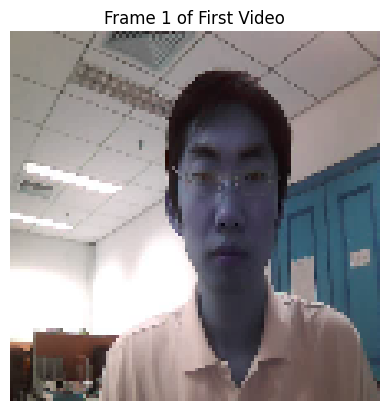

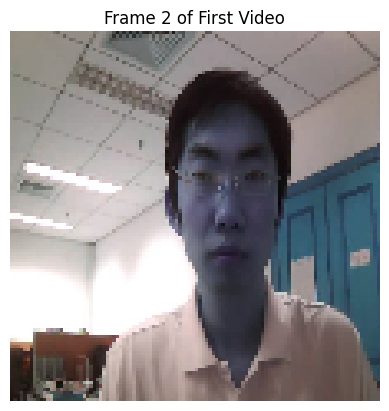

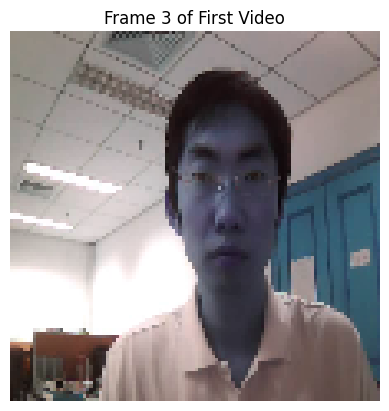

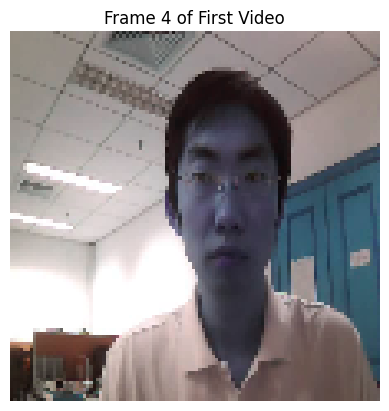

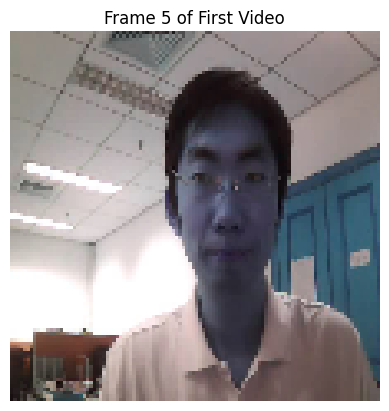

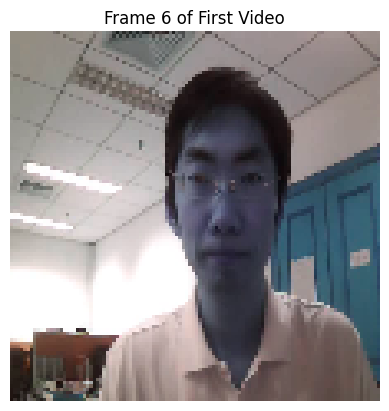

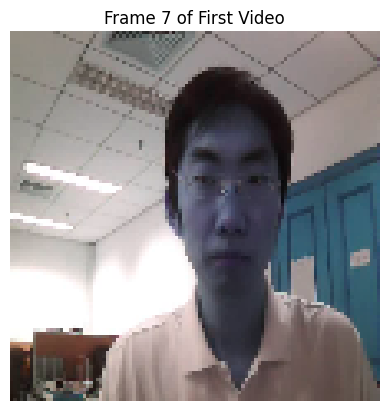

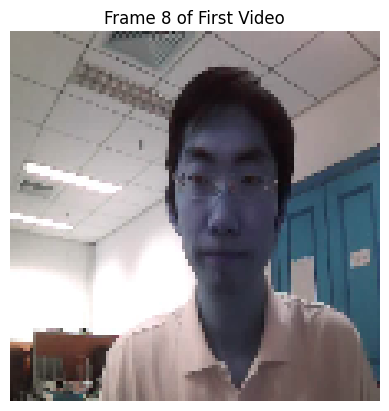

In [16]:
for frames, labels in train_loader:  # Unpack frames and labels
    for i in range(frames.size(1)):  # frames.size(1) gives the number of frames in the first video
        plt.imshow(frames[0][i].permute(1, 2, 0).numpy())  # Show the i-th frame of the first video
        plt.axis('off')  # Hide axis
        plt.title(f'Frame {i + 1} of First Video')
        plt.show()
    
    break  # Exit after the first batch

#### Check data shape

In [17]:
# Check the length of the train dataset
print("Number of videos in train dataset:", len(train_dataset))

# Check the return value of the first item in the dataset
sample_frames, sample_label = train_dataset[0]  # Get the first video
print("Return value for the first video (frames, label):", (sample_frames, sample_label))

# Check the shape of the frames
if isinstance(sample_frames, torch.Tensor):
    print("Shape of frames for the first video:", sample_frames.shape)
else:
    print("The first video frames are not a tensor, inspect further.")


Number of videos in train dataset: 240
Return value for the first video (frames, label): (tensor([[[[145, 147, 147,  ..., 160, 160, 158],
          [145, 147, 147,  ..., 157, 157, 154],
          [147, 147, 147,  ..., 157, 157, 155],
          ...,
          [ 34,  37,  39,  ..., 102, 100,  94],
          [ 31,  34,  30,  ...,  92,  95, 104],
          [ 29,  52,  28,  ..., 102, 101, 101]],

         [[140, 142, 142,  ..., 145, 147, 141],
          [140, 142, 142,  ..., 142, 144, 137],
          [142, 142, 142,  ..., 142, 144, 138],
          ...,
          [ 20,  28,  35,  ...,  89,  91,  87],
          [ 17,  25,  26,  ...,  89,  90,  93],
          [ 15,  43,  24,  ...,  87,  89,  89]],

         [[125, 127, 127,  ..., 141, 138, 142],
          [125, 127, 127,  ..., 138, 135, 138],
          [127, 127, 127,  ..., 137, 135, 139],
          ...,
          [ 18,  25,  31,  ...,  85,  83,  85],
          [ 14,  22,  22,  ...,  84,  82,  90],
          [ 13,  40,  20,  ...,  84,  82,  86

### Extract Features

In [18]:
def feature_extract(loader):
    features_list, labels_list = [], []
    with torch.no_grad():
        for frames, labels in loader:
            batch_size = frames.size(0)
            
            # Reshape frames: [B, C, T, H, W]
            frames = frames.view(batch_size, 3, frames.size(1), 112, 112)
            
            # Normalize pixel values to [0, 1]
            frames = frames.float() / 255.0
            
            # Extract features using the model
            features = model(frames)

            features_list.append(features)
            labels_list.append(labels)

    # Concatenate the lists into tensors
    features = torch.cat(features_list, dim=0)  # Concatenate features
    labels = torch.cat(labels_list, dim=0)      # Concatenate labels
        
    return features, labels

In [19]:
train_features, train_labels = feature_extract(train_loader)

In [20]:
print(train_features.shape)
print(train_labels.shape)

torch.Size([240, 1280])
torch.Size([240])


In [21]:
test_features, test_labels = feature_extract(test_loader)

In [22]:
print(test_features.shape)
print(test_labels.shape)

torch.Size([360, 1280])
torch.Size([360])


### Evaluation

In [23]:
train_features_np = train_features.numpy()  # Convert training features to NumPy array
train_labels_np = train_labels.numpy()      # Convert training labels to NumPy array
test_features_np = test_features.numpy()    # Convert testing features to NumPy array
test_labels_np = test_labels.numpy()        # Convert testing labels to NumPy array

In [24]:
print(train_features_np.shape)
print(train_labels_np.shape)
print(test_features_np.shape)
print(test_labels_np.shape)

(240, 1280)
(240,)
(360, 1280)
(360,)


In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [26]:
# Train an XGB classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(train_features_np, train_labels)

# Test the SVM classifier on the test set
xgb_predictions = xgb_classifier.predict(test_features_np)

# Evaluate the classifier
accuracy = accuracy_score(test_labels, xgb_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print detailed classification report
print(classification_report(test_labels, xgb_predictions))

c:\Users\andre\anaconda3\envs\python-cpu\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 77.78%
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       240
           1       0.71      0.57      0.63       120

    accuracy                           0.78       360
   macro avg       0.76      0.72      0.74       360
weighted avg       0.77      0.78      0.77       360



In [27]:
import numpy as np

In [28]:
# Calculate the counts
TP = np.sum((xgb_predictions == 1) & (test_labels_np == 1))  # True Positives
TN = np.sum((xgb_predictions == 0) & (test_labels_np == 0))  # True Negatives
FP = np.sum((xgb_predictions == 1) & (test_labels_np == 0))  # False Positives
FN = np.sum((xgb_predictions == 0) & (test_labels_np == 1))  # False Negatives

# Calculate FAR
FAR = FP / (FP + TN) if (FP + TN) > 0 else 0  # Avoid division by zero

print(f'False Acceptance Rate (FAR): {FAR * 100:.2f}%')

False Acceptance Rate (FAR): 11.67%
